<a href="https://colab.research.google.com/github/itripathi423-a11y/Concept-of-AI/blob/master/Worksheet_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

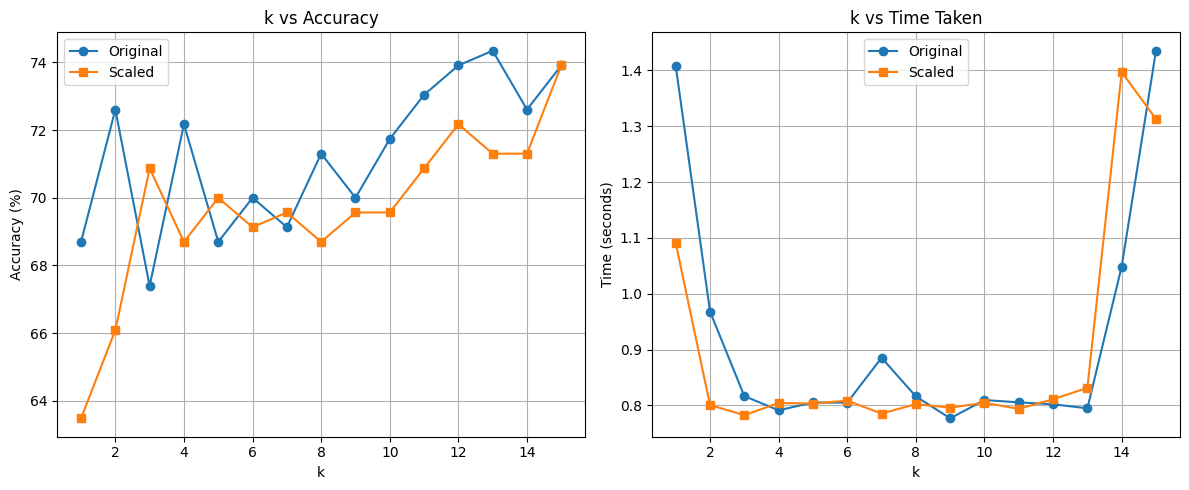

Optimal k for original data: 13 (Accuracy: 74.35%)
Optimal k for scaled data: 15 (Accuracy: 73.91%)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(42)

# Load dataset
data = pd.read_csv("diabetes_.csv")

print(data.head())
print(data.info())
print(data.describe())

print(data.isnull().sum())

if data.isnull().sum().any():
    missing_info = data.isnull().sum() / len(data) * 100
    for column in data.columns:
        if missing_info[column] > 10:
            data[column].fillna(data[column].mean(), inplace=True)
        else:
            data.dropna(subset=[column], inplace=True)

X = data.drop(columns=['Outcome']).values
y = data['Outcome'].values

def train_test_split_scratch(X, y, test_size=0.3, random_seed=42):
    np.random.seed(random_seed)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    test_split_size = int(len(X) * test_size)
    test_indices = indices[:test_split_size]
    train_indices = indices[test_split_size:]
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_scratch(X, y, test_size=0.3)

def euclidean_distance(point1, point2):
    if point1.shape != point2.shape:
        raise ValueError("Points must have the same dimensions.")
    distance = np.sqrt(np.sum((point1 - point2) ** 2))
    return distance

def knn_predict_single(query, X_train, y_train, k=3):
    distances = [euclidean_distance(query, x) for x in X_train]
    sorted_indices = np.argsort(distances)
    nearest_indices = sorted_indices[:k]
    nearest_labels = y_train[nearest_indices]
    prediction = np.bincount(nearest_labels).argmax()
    return prediction

def knn_predict(X_test, X_train, y_train, k=3):
    predictions = [knn_predict_single(x, X_train, y_train, k) for x in X_test]
    return np.array(predictions)

def compute_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy

predictions = knn_predict(X_test, X_train, y_train, k=3)
accuracy = compute_accuracy(y_test, predictions)
print(f"Accuracy of the KNN model on the test set: {accuracy:.2f}%")

def scale_features(X_train, X_test):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

predictions_scaled = knn_predict(X_test_scaled, X_train_scaled, y_train, k=3)
accuracy_scaled = compute_accuracy(y_test, predictions_scaled)
print(f"Accuracy of the KNN model on the scaled test set: {accuracy_scaled:.2f}%")

def experiment_knn_k_values(X_train, y_train, X_test, y_test, k_values, scaled=False):
    accuracies = {}
    times = {}
    for k in k_values:
        start_time = time.time()
        predictions = knn_predict(X_test, X_train, y_train, k=k)
        end_time = time.time()
        accuracy = compute_accuracy(y_test, predictions)
        accuracies[k] = accuracy
        times[k] = end_time - start_time
        print(f"k={k}: Accuracy = {accuracy:.2f}%, Time = {times[k]:.4f}s")
    return accuracies, times

k_values = list(range(1, 16))
accuracies_original, times_original = experiment_knn_k_values(X_train, y_train, X_test, y_test, k_values, scaled=False)
accuracies_scaled, times_scaled = experiment_knn_k_values(X_train_scaled, y_train, X_test_scaled, y_test, k_values, scaled=True)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(k_values, [accuracies_original[k] for k in k_values], marker='o', label='Original')
plt.plot(k_values, [accuracies_scaled[k] for k in k_values], marker='s', label='Scaled')
plt.xlabel('k')
plt.ylabel('Accuracy (%)')
plt.title('k vs Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(k_values, [times_original[k] for k in k_values], marker='o', label='Original')
plt.plot(k_values, [times_scaled[k] for k in k_values], marker='s', label='Scaled')
plt.xlabel('k')
plt.ylabel('Time (seconds)')
plt.title('k vs Time Taken')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

optimal_k_original = max(accuracies_original, key=accuracies_original.get)
optimal_k_scaled = max(accuracies_scaled, key=accuracies_scaled.get)
print(f"Optimal k for original data: {optimal_k_original} (Accuracy: {accuracies_original[optimal_k_original]:.2f}%)")
print(f"Optimal k for scaled data: {optimal_k_scaled} (Accuracy: {accuracies_scaled[optimal_k_scaled]:.2f}%)")
